This is the project from Udacity, I change it and simplify it for here

In [2]:
ls /home/aind2/Data/dogImages/

test/  train/  valid/


In [3]:
datapath = '/home/aind2/Data/'

# 1. Read Data

另一种从文件夹读取数据的办法，其实只读了文件名和target（需要文件夹结果），读到的data似乎无效

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(datapath + 'dogImages/train')
valid_files, valid_targets = load_dataset(datapath + 'dogImages/valid')
test_files, test_targets = load_dataset(datapath + 'dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob(datapath + "dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### pre-process data
读数据其实还是用的keras的load_img，然后expand dim，再stack起来的，当然也可以用Generator一起搞定

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm    #add processing bar for loop

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### make a prediction with pre-trained ResNet-50

In [6]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

我还是用正常的读数据办法了吧

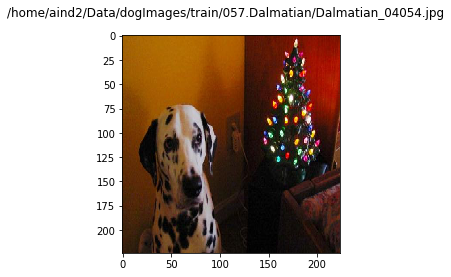

In [7]:
import matplotlib.pyplot as plt

img = image.load_img(train_files[1], target_size=(224, 224))

fig = plt.figure()
plt.imshow(img)
fig.suptitle(train_files[1])
plt.show()

In [8]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = ResNet50_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02110341', 'dalmatian', 0.99987924), ('n02109047', 'Great_Dane', 3.4242694e-05), ('n02100735', 'English_setter', 2.5213245e-05)]


# Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [9]:
ls

Dog_Breed_Classifier.ipynb  DogResnet50Data.npz  weights.best.resnet50.hdf5


udacity的project提供了算好的features，所以我就直接用了，具体操作方式其实和dogs vs cats里是一样的的

In [10]:
bottleneck_features = np.load('DogResnet50Data.npz')
bottlenect_train = bottleneck_features['train']
bottlenect_valid = bottleneck_features['valid']
bottlenect_test = bottleneck_features['test']

In [11]:
bottlenect_train.shape

(6680, 1, 1, 2048)

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential


model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=bottlenect_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 280,709
Trainable params: 276,613
Non-trainable params: 4,096
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(bottlenect_train, train_targets, 
          validation_data=(bottlenect_valid, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 2.0666 - acc: 0.5097 - val_loss: 0.9817 - val_acc: 0.7485
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.6589 - acc: 0.8254 - val_loss: 0.7818 - val_acc: 0.7988
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.3982 - acc: 0.8966 - val_loss: 0.7522 - val_acc: 0.7868
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.2701 - acc: 0.9334 - val_loss: 0.7952 - val_acc: 0.7760
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1824 - acc: 0.9554 - val_loss: 0.8020 - val_acc: 0.7856
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.1439 - acc: 0.9636 - val_loss: 0.7620 - val_acc: 0.7844
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.1044 - acc: 0.9760 - val_loss: 0.7798 - val_acc: 0.7892
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0921 - ac

In [14]:
model.optimizer.lr = 0.0001
model.fit(bottlenect_train, train_targets, 
          validation_data=(bottlenect_valid, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 1s - loss: 0.0284 - acc: 0.9922 - val_loss: 0.9360 - val_acc: 0.7988
Epoch 2/10
6680/6680 [==============================] - 1s - loss: 0.0196 - acc: 0.9958 - val_loss: 0.9780 - val_acc: 0.7868
Epoch 3/10
6680/6680 [==============================] - 1s - loss: 0.0207 - acc: 0.9948 - val_loss: 0.9628 - val_acc: 0.8012
Epoch 4/10
6680/6680 [==============================] - 1s - loss: 0.0257 - acc: 0.9933 - val_loss: 0.9642 - val_acc: 0.7940
Epoch 5/10
6680/6680 [==============================] - 1s - loss: 0.0213 - acc: 0.9937 - val_loss: 0.9471 - val_acc: 0.8096
Epoch 6/10
6680/6680 [==============================] - 1s - loss: 0.0189 - acc: 0.9943 - val_loss: 0.9976 - val_acc: 0.7928
Epoch 7/10
6680/6680 [==============================] - 1s - loss: 0.0196 - acc: 0.9948 - val_loss: 1.0126 - val_acc: 0.7988
Epoch 8/10
6680/6680 [==============================] - 1s - loss: 0.0183 - ac

### Test the model

In [15]:
### TODO: Calculate classification accuracy on the test dataset.
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in bottlenect_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.3828%


In [16]:
def predict_by_model(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    fig = plt.figure()
    plt.imshow(img)
    fig.suptitle(image_path)
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(x)
    predicted_vector = model.predict(bottleneck_feature)

    print(dog_names[np.argmax(predicted_vector)])

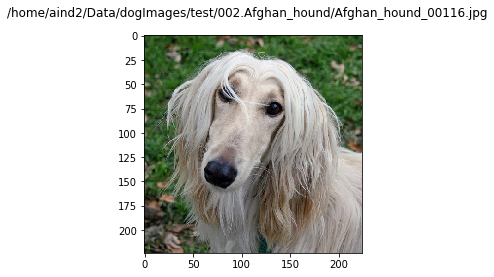

Images/train/002.Afghan_hound


In [17]:
predict_by_model(test_files[10])